# Structure prediction in lncRNA 
This notebook shows the predicted structures of selected lncRNAs, for each method in the review, using the biochemical probing scores and probing-guided  structures as reference.

## Setup

In [ ]:
import os

!sudo apt -qq install cpanminus && sudo cpanm Graph

!pip -q install biopython
!pip -q install path
!pip -q install Orange3
!pip install wget

# RNA plotting library
!git clone https://github.com/DasLab/draw_rna.git
!mv draw_rna draw_rna_directory
os.chdir("draw_rna_directory/")
!pip install .
os.chdir("../")
import draw_rna.draw as draw

import re
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
import wget
from Bio import SeqIO
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Download and decompress RNAstructure
!wget -q http://rna.urmc.rochester.edu/Releases/current/RNAstructureLinuxTextInterfaces64bit.tgz
!tar xfz RNAstructureLinuxTextInterfaces64bit.tgz

repository_path = "https://raw.githubusercontent.com/sinc-lab/lncRNA-folding/main/"

## Metrics and auxiliary functions

In [2]:
def dot2ct(in_name, out_name):
    """
    Convert dotbracket to ct using RNAstructure library
   
    Parameters
    ----------
    in_name : str
        Fasta filename with seq_id, sequence and structure (dotbracket)
    out_name : str
        Filename to save ct format
    """
    tab_path = "RNAstructure/data_tables"
    dot2ct_path = "RNAstructure/exe/dot2ct"

    os.system(f"export DATAPATH={tab_path}; {dot2ct_path} {in_name} {out_name}")

def rnastructure_scorer(reference_fasta, prediction_fasta):
    """
    Compares reference and predicted structures and returns RNAstructure scores
   
    Parameters
    ----------
    reference_fasta : str
        Fasta filename with seq_id, sequence and structure with reference
    prediction_fasta : str
        Fasta filename with seq_id, sequence and structure with prediction

    Returns
    -------
    s, p, f1
        Base-pairing sensibility, precision and f1-score
    """
    # Convert input dot files into ct files
    # http://rna.urmc.rochester.edu/Text/File_Formats.html#CT
    tab_path = "RNAstructure/data_tables"
    dot2ct_path = "RNAstructure/exe/dot2ct"
    scorer_path = "RNAstructure/exe/scorer"

    os.system(f"export DATAPATH={tab_path}; {dot2ct_path} {prediction_fasta} tmp_pred.ct")
    os.system(f"export DATAPATH={tab_path}; {dot2ct_path} {reference_fasta} tmp_true.ct")

    # Calculate metrics
    s, p, f1 = 0, 0, 0  # if the predictions are invalid and the scorer fails, scores are 0 
    os.system(f"export DATAPATH={tab_path}; {scorer_path} tmp_pred.ct tmp_true.ct tmp_score.txt")
    if os.path.isfile("tmp_score.txt"): # scorer exited sucessfully
        for line in open('tmp_score.txt'):
            if 'Sensitivity' in line:
                s = float(line.strip().split()[-1][:-1])/100
            if 'PPV' in line:
                p = float(line.strip().split()[-1][:-1])/100
        if s + p != 0:
            f1 = 2*s*p/(s + p)
        
    # clean tmp files
    for f in os.listdir("./"):
        if "tmp_" in f:
            os.remove(f)

    return s, p, f1

def split_fasta_seq(seq_str):
    """
    split sequence id, sequence and structure from string
   
    Parameters
    ----------
    seq_str : str
        String as read from SeqIO.parse
    
    Returns
    -------
    seq, struct
        Sequence and structure strings
    """
    ind = re.search("[.()\[\]{}<>]", seq_str).start()

    seq = seq_str[:ind].lower().replace('t', 'u')
    struct = seq_str[ind:ind*2]
    
    return seq, struct

def write_fasta(fname, seqid, seq, struct):
    """
    Writes fasta file using one item per line

    Parameters
    ----------
    fname : str
        Output filename
    seqid, seq, struct : str
        Sequence id, sequence and structure to write
    """
    with open(fname, "w") as fin:
        fin.write(f">{seqid}\n")
        fin.write(f"{seq}\n")
        fin.write(f"{struct}\n")

def scale_probing(scores, source):
    """
    Scale the structural probing scores in the range [0, 1], where 0 is not 
    paired and 1 is paired.
        
    Parameters
    ----------
    scores : array[float]
        Structural probing scores, same size as the RNA sequence
    source : str
        Probing method from the following:

        'PARS': original log scale (cite2010)
        
        'nextPARS': from linear scores (SHAPE-like by Uciel Chorostecki2021 https://doi.org/10.1007/978-1-0716-1307-8_4)
                    "score for each nucleotide that ranges from −1.0 (highest preference for single strand)
                    to 1.0 (highest preference for double-strand)."
                    https://github.com/Gabaldonlab/nextPARS_docker
        
        'SHAPE': input scores in (0,1) 0=>match (double strand) and 1=>non-match (single strand)
                (Chillon2015 https://dx.doi.org/10.1016/bs.mie.2015.01.008)
                preprocessing: https://colab.research.google.com/drive/1uFgjb4uesAvYHPRhFqfkyMJ5bQec8rgP
                - mark with -999 the undetermined nucleotides
                - remove negative values (replace with -999)
                - replace scores>1 with 1.0
                - (do not scale/transform values in the range (0,1) because they have a particular meaning in the standard.
                output 1-score
        'SHAPE-D': apply ln and then linear scale
                (Deigan2009 https://doi.org/10.1073/pnas.0806929106)
                (default in RNAfold https://www.tbi.univie.ac.at/RNA/RNAfold.1.html)
                [HOTAIR, PAN]?
        
        np.nan: nt without measurement => assing 0.5 (then exclude them with tol>0.0
        in the MAS function)
    
    Returns
    -------
    nscores
        Normalized scores
    """
    s = scores.copy()
    
    if source=="PARS":
        nscores = (s + 7) / (2*7)
    elif source=="nextPARS":
        nscores = (s + 1) / 2 
    elif source=="SHAPE":
        nscores = 1 - s
    elif source=="SHAPE-D":
        shD = 1.8*np.log(s+1)-0.6
        shD[shD<-2.0] = -2.0
        shD[shD>2.0] = 2.0
        nscores = (shD+2.0)/4.0
    else:
        print("WARNING: scaling not applied")
        nscores = s

    nscores[np.isnan(nscores)] = 0.5    
    return nscores 

def mas_score(pred, nscores, tol=0.1):
    """
    Mean absolute similarity (MAS) between binary predictions and biochemical 
    probing scores.   

    Parameters
    ----------
    pred : array[int]
        Paired-unpaired prediction for each nucleotid in {0, 1}, where 0 is 
        unpaired and 1 is paired
    nscores : array[float]
        Probing score for each nucleotid in [0, 1], where 0 is high score for 
        unpaired and 1 high score for paired
    tol : float
        Nucleotids with (0.5 - tol/2) < score < (0.5 + tol/2)  are ignored
    
    Returns
    -------
    MASu, MASp, MAS : float
        paired MAS, unpaired MAS and average MAS. 
    """
    i_pos = nscores > 0.5 + tol/2
    i_neg = nscores <= 0.5 - tol/2
    Npos = sum(i_pos)
    Nneg = sum(i_neg)
       
    diff = pred - nscores
    
    mas_pos = 1 - np.absolute(diff[i_pos]).mean()
    mas_neg = 1 - np.absolute(diff[i_neg]).mean()
    
    # best and worst cases for normalization
    ref_ideal = np.ones((len(nscores),))
    ref_ideal[nscores<=tol/2+0.5] = 0.0
    
    diff_ideal = ref_ideal - nscores
    diff_worst = (1-ref_ideal) - nscores
    
    max_mas_pos = 1 - np.absolute(diff_ideal[i_pos]).mean() 
    max_mas_neg = 1 - np.absolute(diff_ideal[i_neg]).mean()     
    min_mas_pos = 1 - np.absolute(diff_worst[i_pos]).mean() 
    min_mas_neg = 1 - np.absolute(diff_worst[i_neg]).mean()     
    
    MASp = (mas_pos - min_mas_pos) / (max_mas_pos - min_mas_pos) 
    MASu = (mas_neg - min_mas_neg) / (max_mas_neg - min_mas_neg) 
    
    # simple average
    ave_mas = 1 - np.absolute(diff[i_pos | i_neg]).mean() 
    
    # normalized average
    max_ave_mas = 1 - np.absolute(diff_ideal[i_pos | i_neg]).mean()
    min_ave_mas = 1 - np.absolute(diff_worst[i_pos | i_neg]).mean()
    MAS = (ave_mas - min_ave_mas) / (max_ave_mas - min_ave_mas) 

    return MASp, MASu, MAS

## Prepare dataset and predictions
Retrieve structure references (dot-bracket), probing scores and predictions of each lncRNA. 

In [3]:
# References
lncRNAs = {}
lncRNAs_fasta = "lncRNAs.fasta"
if not os.path.isfile(lncRNAs_fasta):
    wget.download(f"{repository_path}data/lncRNAs.fasta")
for rec in SeqIO.parse(lncRNAs_fasta, "fasta"):
    lncRNAs[rec.id] = split_fasta_seq(str(rec.seq))

# Probing scores
probing_scores_raw = pd.read_csv(f"{repository_path}data/lncRNAs_probing_scores.csv", index_col=0)

probing_scores = {}
for ID in probing_scores_raw.index:
    if "NORAD" in ID:
        probing_method = "nextPARS"
    elif ID in ["HOTAIR", "CYRANO", "MALAT1", "MEG3","PAN","XIST", 
                "lincRNAp21_IRAlu_Sense", "lincRNAp21_IRAlu_Antisense"]:
        probing_method = "SHAPE"
    else:
        print(f"{ID} normalization is not defined")    
        probing_method = ""
    
    scores = probing_scores_raw.loc[ID].dropna().values
    scores[scores == -999] = np.nan

    probing_scores[ID] = scale_probing(scores, probing_method)

In [4]:
# Reviewed methods sorted by publication date. E2Efold and 2dRNA-Fold were 
# removed because the median F1-value is < .1 in every subset. 
methods = ['CONTRAFold', 'CentroidFold', 'ProbKnot', 'ShapeKnots', 'RNAstructure',
           'contextFold', 'IPknot', 'RNAfold', 'pKiss', 'RNAshapes',
           'LinearFold', 'SPOT-RNA', 'LinearPartition',
           'rna-state-inf', 'MXfold2', 'SPOT-RNA2', 'UFold']

# Load all predictions
predictions = {}
for method in methods:
    
    predictions[method] = {}
    prediction_fasta =  f"{method}.fasta"
    
    if not os.path.isfile(prediction_fasta):
         wget.download(f"{repository_path}predictions/lncRNAs/{method}.fasta")

    # Read each sequence structure
    for rec in SeqIO.parse(prediction_fasta, "fasta"):
        seq, struct = split_fasta_seq(str(rec.seq))        
        predictions[method][rec.id] = struct

## Compute global metrics
Compare the predictions with references of each lncRNA. The references includes the dot-bracket structure and the structural probing score

In [5]:
results = []   
tmp_pred = 'pred.fasta'
tmp_ref = 'label.fasta'

for method in tqdm(methods):
    for ID in  predictions[method]:
        # Reference
        sequence = lncRNAs[ID][0]
        struct_reference = lncRNAs[ID][1]
        
        # Prediction
        struct = predictions[method][ID]
        pairing_prediction = [0 if n == "." else 1 for n in struct]  

        # MAS score
        MASp, MASu, MAS = np.nan, np.nan, np.nan
        if ID in probing_scores: 
            MASp, MASu, MAS = mas_score(pairing_prediction, probing_scores[ID])
            
        # Remove pseudoknots for F1 scoring 
        for c in np.unique(list(struct)):
            if c not in ["(", ")", "."]:
                struct = struct.replace(c, ".")

        write_fasta(tmp_ref, ID, sequence, struct_reference)
        write_fasta(tmp_pred, ID, sequence, struct)
        
        # Prediction vs dot-bracket structure
        s, p, f1 = rnastructure_scorer(tmp_ref, tmp_pred)
        os.remove(tmp_pred)
        os.remove(tmp_ref)

        results.append([ID, method, struct, MASp, MASu, MAS, 
                        s, p, f1])

results = pd.DataFrame(results, columns=["ID", "Method", "Struct", 
                                         "MASp", "MASu", "MAS",
                                         "Sensibility", "Precision", "F1"])

  0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 22.2% of the points cannot be placed; yo

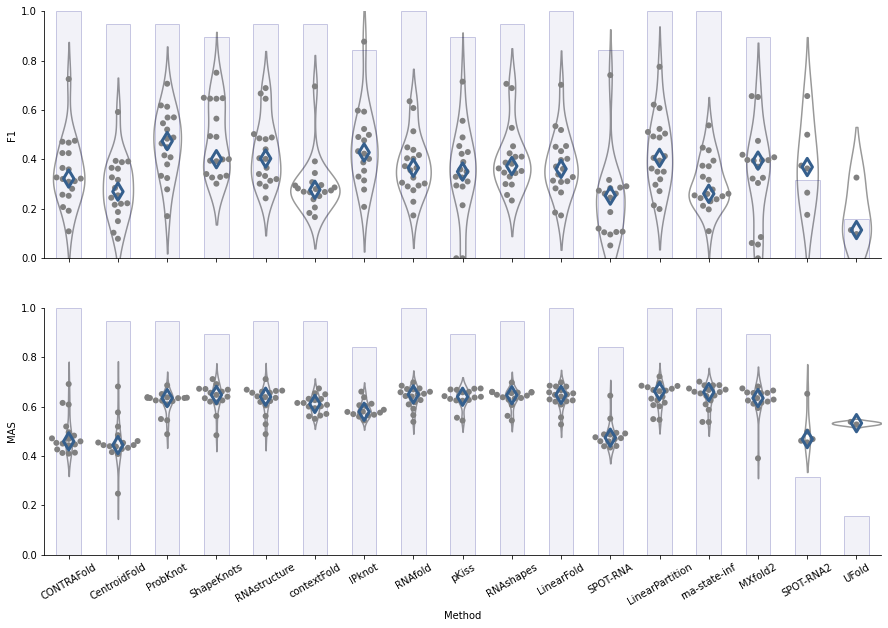

In [6]:
# Coverage
nc = results.loc[:, ['Method', 'F1']].groupby(by='Method', sort=False).count().values
coverage = np.squeeze(nc/len(results.ID.unique()))

# Sort sequences by length
seq_len = [len(lncRNAs[k][0]) for k in lncRNAs]
seq_names = [k for k in lncRNAs]
seq_names = [seq_names[p] for p in np.argsort(seq_len)]

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

for ax, metric in zip(axes, ["F1", "MAS"]):

    ax.bar(np.arange(len(coverage)), coverage, color=[.0, .0, .5, .05],
        edgecolor=[.0, .0, .5, .2], width=.5)

    sns.violinplot(data=results, x='Method', y=metric, width=1, inner=None, 
                color="white", ax=ax);

    median = results.groupby(by="Method", sort=False)[metric].median()
    ax.scatter(x=range(len(median)), y=median, marker="d", facecolors="none", 
                edgecolors=plt.cm.viridis(.3), s=150, linewidth=3, zorder=10)

    sns.swarmplot(data=results, x='Method', y=metric, color="gray",# hue='ID', hue_order=seq_names,
                size=6, ax=ax);
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim([0, 1]);
    
    if metric == "F1":
        ax.legend([],[], frameon=False)
        ax.set_xticklabels([]);
        ax.set_xlabel("");
    
#ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);
    

**F1 distribution sorted by lncRNA length**

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


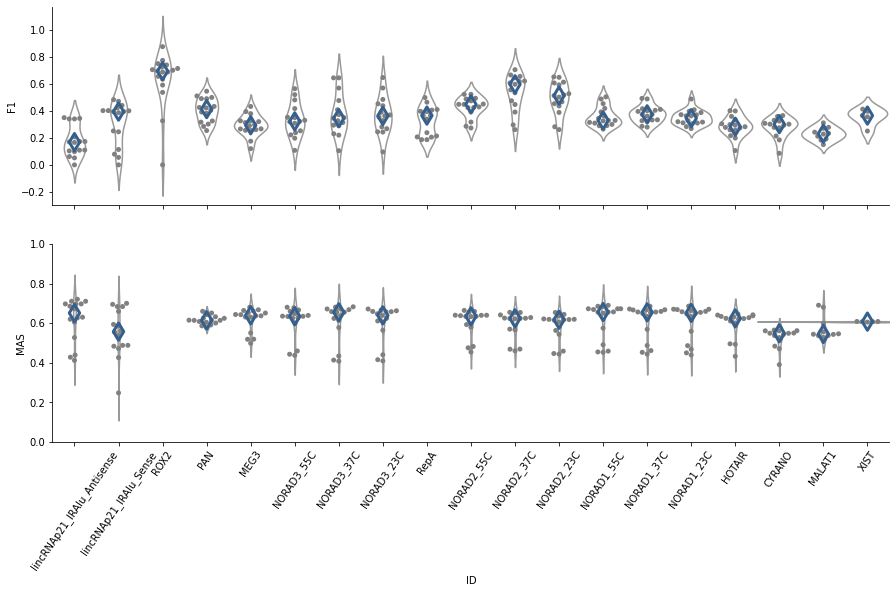

In [9]:
from numpy.ma.core import masked_outside
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

for ax, metric in zip(axes, ["F1", "MAS"]):
    w = 1
    if metric == "MAS":
        w = 5
    sns.violinplot(data=results, x='ID', y=metric, width=w, inner=None, 
                color="white", ax=ax, order=seq_names);

    median = results.groupby(by="ID")[metric].median().loc[seq_names]

    ax.scatter(x=range(len(median)), y=median, marker="d", facecolors="none", 
                edgecolors=plt.cm.viridis(.3), s=150, linewidth=3, zorder=10)

    sns.swarmplot(data=results, x='ID', y=metric, color="gray",# hue='Method', hue_order=methods,
                size=5, ax=ax, order=seq_names);

    ax.set_xticklabels(ax.get_xticklabels(),rotation=55);
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.ylim([0, 1])
    if metric == "F1":
        ax.set_xticklabels([]);
        ax.set_xlabel("");


## NORAD1 - 37°C


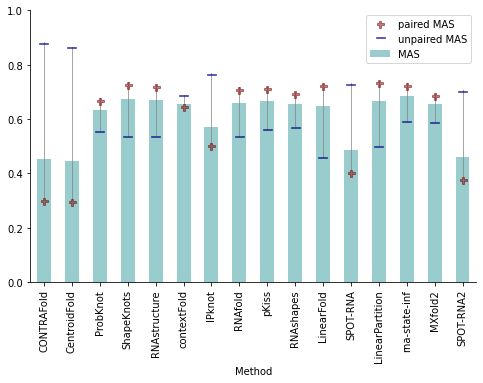

In [15]:
ID = "NORAD1_37C" 

fig, ax = plt.subplots(figsize=(8, 5))
norad = results.loc[results.ID == ID]

norad.plot(x="Method", y=["MAS"], kind="bar", ax=ax, color=[0.0,0.5,0.5,0.4])

x = np.arange(len(norad.Method.unique()))
ax.plot((x,x), ([p+0.01 for p in norad["MASp"]], [n+0.01 for n in norad["MASu"]]), color=[0.5,0.5,0.5,0.7], linewidth=1)
ax.plot(x, norad["MASp"], marker="P", color=[.5, 0, 0, .5], markersize=7, linewidth=0, label="paired MAS")
ax.plot(x-0.02, norad["MASu"], marker="$-$", color=[0, 0, .5, .5], markersize=10, linewidth=0, label="unpaired MAS")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim([0, 1])
#ax.legend([],[], frameon=False)
ax.legend();

#### Structure comparison between predictions and references
This section shows the top-3 and worst predictions (according to MAS score and F1) compared with the dot-bracket reference  

Interpreting color string as integer values
Interpreting color string as integer values
Interpreting color string as integer values
Interpreting color string as integer values
Interpreting color string as integer values
Interpreting color string as integer values
Interpreting color string as integer values
Interpreting color string as integer values
Interpreting color string as integer values
Interpreting color string as integer values


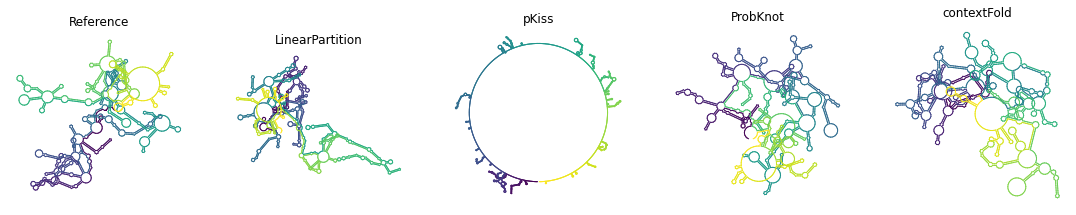

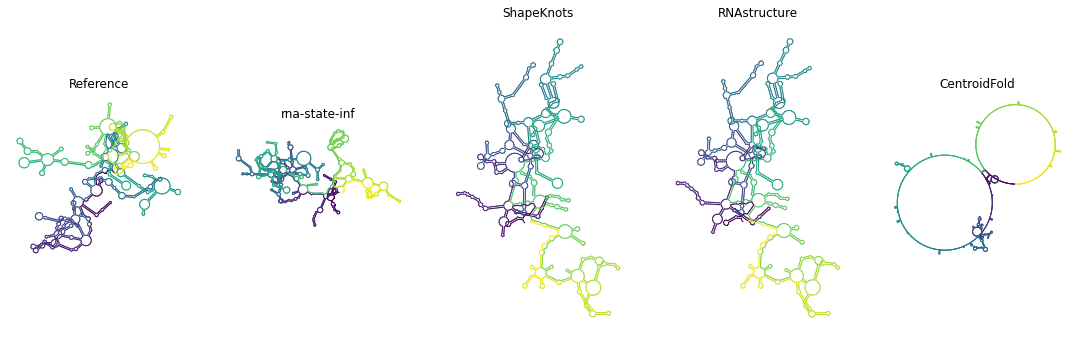

In [16]:
seq, struct_ref = lncRNAs[ID] # Reference

im_width = len(seq)/100

colors = np.arange(len(seq)) # color map from 5' to 3'

for metric in ["F1", "MAS"]:
    res_sorted = results[(results.ID == ID) & (results.Struct.str.len() > 0)].sort_values(by=metric, ascending=False)
    
    fig, axes = plt.subplots(1, 5, figsize=(im_width, im_width))
    axes = axes.ravel()

    for k, ax in enumerate(axes):
        if k == 0:  # reference
            struct = struct_ref
            title = "Reference"
        else:  
            if k == len(axes) - 1: # the worst prediction 
                ind = -1
            else: # top-3 predictions
                ind = k - 1
            pred = res_sorted.iloc[ind]
            struct = pred.Struct 
            title = pred.Method

        ax.set_title(title)
        
        draw.draw_rna(seq, struct, colors, cmap_name = "viridis", ax=ax, line=True)

        # circular plot
        write_fasta(f"tmp{k}.dbn", f"{ID}_{title}", seq, struct)
        dot2ct(f"tmp{k}.dbn", f"tmp{k}.ct")

        if k > 0:
            os.system(f"export DATAPATH=RNAstructure/data_tables; RNAstructure/exe/CircleCompare tmp{k}.ct --svg -n 1 -u tmp0.ct circplot{k}_{metric}")